###### Content under Creative Commons Attribution license CC-BY 4.0, code under BSD 3-Clause License © 2018  by D. Koehn, heterogeneous models are from [this Jupyter notebook](https://krischer.github.io/seismo_live_build/html/Computational%20Seismology/The%20Finite-Difference%20Method/fd_ac2d_heterogeneous_wrapper.html) by Heiner Igel ([@heinerigel](https://github.com/heinerigel)), Florian Wölfl and Lion Krischer ([@krischer](https://github.com/krischer)) which is a supplemenatry material to the book [Computational Seismology: A Practical Introduction](http://www.computational-seismology.org/), notebook style sheet by L.A. Barba, N.C. Clementi

In [1]:
# Execute this cell to load the notebook's style sheet, then ignore it
from IPython.core.display import HTML
css_file = '../style/custom.css'
HTML(open(css_file, "r").read())

# 2D acoustic FD modelling of the Marmousi-2 model

In this notebook, we will apply all the knowledge about FD modelling, we covered so far. While the modelling examples in the last lesson where quite simple, we now calculate the 2D acoustic wave propagation in a more realistic problem called the **Marmousi-2 model**.
Developed in the 1990s by the French Petroleum Institute (IFP) ([Versteeg, 1994](https://library.seg.org/doi/abs/10.1190/1.1437051)), the Marmousi model is a widely used benchmark problem for seismic imaging and inversion techniques. Beside the original acoustic version of the model, an elastic version was developed by [Martin et al. (2006)](https://library.seg.org/doi/abs/10.1190/1.2172306).

The Marmousi-2 model consists of a 460 m thick water layer above an elastic subseafloor model.  The sediment model is very simple near the left and right boundaries but rather complex in the centre. At both sides, the subseafloor is approximately horizontally layered, while steep thrust faults are disturbing the layers in the centre of the model. Embedded in the thrust fault system and layers are small scale hydrocarbon reservoirs.

In this notebook you will learn how to setup the basic parameters, required to model a seismic acquistion geometry:

Setup and model the 2D acoustic wave propagation in the Marmousi-2 model:

- Define the model discretization based on the given Marmousi-2 P-wave velocity model
- Calculate the central frequency $f_0$ of the source wavelet based on the grid dispersion criterion 

\begin{equation}
dx \le \frac{vp_{min}}{N_\lambda f_0}, \nonumber
\end{equation}

which you can use for the FD modelling run, for the pre-defined $dx$ of the Marmousi-2 model , minimum P-wave velocity $vp_{min}$ and $N_\lambda = 4$ gridpoints per dominant wavelength.
- Starting a modelling run for the Marmousi-2 model. Place an airgun for a central shot at x = 5000 m at a depth = 40 m below the sea surface. Do not forget to calculate an appropriate time step $dt$
- Imagine you place an Ocean-Bottom-Cable (OBC) on the seafloor of the Marmousi-2 model. Calculate an OBC shot gather, by placing receivers at each gridpoint of the Cartesian model in x-direction in a depth of 460 m. Modify the FD code to record seismograms at each receiver position. Do not forget to return the seismograms from the modelling function.
- Plot the OBC-seismograms produced by the finite-difference modelling code.

In [2]:
# Import Libraries 
# ----------------
import numpy as np
from numba import jit
import matplotlib
import matplotlib.pyplot as plt
from pylab import rcParams

# Ignore Warning Messages
# -----------------------
import warnings
warnings.filterwarnings("ignore")

from mpl_toolkits.axes_grid1 import make_axes_locatable

The elastic version of the Marmousi-2 model, together with FD modelled high frequency shot gather data is available from [here](http://www.agl.uh.edu/downloads/downloads.htm). The central part of the P-wave velocity model of the Marmousi-2 with the spatial discretization: 

$nx = 500$ gridpoints

$nz = 174$ gridpoints

$dx = dz = 20\; m$

is available as IEEE little endian binary file `marmousi_II_marine.vp` in the `marmousi-2` directory. It can be imported to Python with the following code snippet:

In [3]:
# Import Marmousi-2 Vp model
# --------------------------

# DEFINE MODEL DISCRETIZATION HERE!
nx = 500       # number of grid points in x-direction
nz = 174       # number of grid points in z-direction
dx = 20.0      # spatial grid point distance in x-direction (m)
dz = dx        # spatial grid point distance in z-direction (m)

# Define model filename
name_vp = "marmousi-2/marmousi_II_marine.vp"

# Open file and write binary data to vp
f = open(name_vp)
data_type = np.dtype ('float32').newbyteorder ('<')
vp = np.fromfile (f, dtype=data_type)

# Reshape (1 x nx*nz) vector to (nx x nz) matrix 
vp = vp.reshape(nx,nz)

After reading the model into Python, we can take a look at it ...

Text(0, 0.5, 'z [m]')

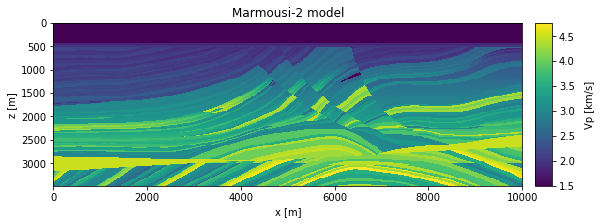

In [4]:
# Plot Marmousi-2 vp-model
# ------------------------

# DEFINE XMAX, ZMAX AND MODEL EXTENSION HERE!
xmax = nx * dx
zmax = nz * dz
extent = [0, xmax, zmax, 0]

fig = plt.figure(figsize=(12,3))  # define figure size

image = plt.imshow((vp.T)/1000, cmap=plt.cm.viridis, interpolation='nearest', 
                   extent=extent)

cbar = plt.colorbar(aspect=10, pad=0.02)
cbar.set_label('Vp [km/s]', labelpad=10)
plt.title('Marmousi-2 model')
plt.xlabel('x [m]')
plt.ylabel('z [m]')

In [5]:
# Definition of modelling parameters
# ----------------------------------
# DEFINE MAXIMUM RECORDING TIME HERE!
tmax = 6.0    # maximum recording time of the seismogram (s)

# DEFINE YOUR SHOT POSITION HERE!
xsrc = 5000.0 # x-source position (m)
zsrc = 40.0   # z-source position (m)

# calculate maximum frequency according to grid dispersion criterion
N_lam = 4 

# CALCULATE DOMINANT FREQUENCY OF THE SOURCE WAVELET HERE!
f0   = np.min(vp) / (dx * N_lam) # dominant frequency of the source (Hz)
print("f0 = ", f0, " Hz")
t0   = 4.0/f0   # source time shift (s)

isnap = 2  # snapshot interval (timesteps)

f0 =  18.75  Hz


In [6]:
@jit(nopython=True) # use JIT for C-performance
def update_d2px_d2pz_3pt(p, dx, dz, nx, nz, d2px, d2pz):
    
    for i in range(1, nx - 1):
        for j in range(1, nz - 1):
                
            d2px[i,j] = (p[i + 1,j] - 2 * p[i,j] + p[i - 1,j]) / dx**2                
            d2pz[i,j] = (p[i,j + 1] - 2 * p[i,j] + p[i,j - 1]) / dz**2
        
    return d2px, d2pz 

In [7]:
# Define simple absorbing boundary frame based on wavefield damping 
# according to Cerjan et al., 1985, Geophysics, 50, 705-708
def absorb(nx,nz):

    FW = 60     # thickness of absorbing frame (gridpoints)    
    a = 0.0053
    
    coeff = np.zeros(FW)
    
    # define coefficients in absorbing frame
    for i in range(FW):    
        coeff[i] = np.exp(-(a**2 * (FW-i)**2))

    # initialize array of absorbing coefficients
    absorb_coeff = np.ones((nx,nz))

    # compute coefficients for left grid boundaries (x-direction)
    zb=0 
    for i in range(FW):
        ze = nz - i - 1
        for j in range(zb,ze):
            absorb_coeff[i,j] = coeff[i]

    # compute coefficients for right grid boundaries (x-direction)        
    zb=0
    for i in range(FW):
        ii = nx - i - 1
        ze = nz - i - 1
        for j in range(zb,ze):
            absorb_coeff[ii,j] = coeff[i]

    # compute coefficients for bottom grid boundaries (z-direction)        
    xb=0 
    for j in range(FW):
        jj = nz - j - 1
        xb = j
        xe = nx - j
        for i in range(xb,xe):
            absorb_coeff[i,jj] = coeff[j]

    return absorb_coeff

In [8]:
# FD_2D_acoustic code with JIT optimization
# -----------------------------------------
def FD_2D_acoustic_JIT(vp, dt,dx,dz,f0,xsrc,zsrc,op):        
    
    # calculate number of time steps nt 
    # ---------------------------------
    nt = (int)(tmax/dt)
    
    # locate source on Cartesian FD grid
    # ----------------------------------
    isrc = (int)(xsrc/dx)  # source location in grid in x-direction
    jsrc = (int)(zsrc/dz)  # source location in grid in x-direction    
    
    # Source time function (Gaussian)
    # -------------------------------
    src  = np.zeros(nt + 1)
    time = np.linspace(0 * dt, nt * dt, nt)

    # 1st derivative of Gaussian
    src  = -2. * (time - t0) * (f0 ** 2) * (np.exp(- (f0 ** 2) * (time - t0) ** 2)) 
    
    # define clip value: 0.1 * absolute maximum value of source wavelet
    clip = 0.5 * max([np.abs(src.min()), np.abs(src.max())]) / (dx*dz) * dt**2
    
    # Define absorbing boundary frame
    # -------------------------------    
    absorb_coeff = absorb(nx,nz)
    
    # Define squared vp-model
    # -----------------------        
    vp2 = vp**2
    
    # Initialize empty pressure arrays
    # --------------------------------
    p    = np.zeros((nx,nz)) # p at time n (now)
    pold = np.zeros((nx,nz)) # p at time n-1 (past)
    pnew = np.zeros((nx,nz)) # p at time n+1 (present)
    d2px = np.zeros((nx,nz)) # 2nd spatial x-derivative of p
    d2pz = np.zeros((nx,nz)) # 2nd spatial z-derivative of p 
    
    # Initialize seismograms 
    # ----------------------
    seis = np.zeros((nx,nt+1))
    jr = 23
        
    # Initalize animation of pressure wavefield 
    # -----------------------------------------    
    fig = plt.figure(figsize=(7,3))  # define figure size
    extent = [0.0,xmax,zmax,0.0]     # define model extension
    
    # Plot Vp-model
    image = plt.imshow((vp.T)/1000, cmap=plt.cm.gray, interpolation='nearest', 
                        extent=extent)    
    
    # Plot pressure wavefield movie
    image1 = plt.imshow(p.T, animated=True, cmap="RdBu", alpha=.75, extent=extent, 
                          interpolation='spline36', vmin=-clip, vmax=clip)    
    plt.title('Pressure wavefield')
    plt.xlabel('x [m]')
    plt.ylabel('z [m]')
           
    plt.ion()    
    plt.show(block=False)
    
    snap_count = 0
    
    # Calculate Partial Derivatives
    # -----------------------------
    for it in range(nt):
    
        # FD approximation of spatial derivative by 3 point operator
        if(op==3):
            d2px, d2pz = update_d2px_d2pz_3pt(p, dx, dz, nx, nz, d2px, d2pz)

        # Time Extrapolation
        # ------------------
        pnew = 2 * p - pold + vp2 * dt**2 * (d2px + d2pz)

        # Add Source Term at isrc
        # -----------------------
        # Absolute pressure w.r.t analytical solution
        pnew[isrc,jsrc] = pnew[isrc,jsrc] + src[it] / (dx * dz) * dt ** 2
        
        # Apply absorbing boundary frame
        # ------------------------------
        p *= absorb_coeff
        pnew *= absorb_coeff
        
        # Remap Time Levels
        # -----------------
        pold, p = p, pnew
        
        # WRITE SEISMOGRAMS HERE!
        seis[:, it] = p[:, jr] 
    
        # display pressure snapshots 
        if (it % isnap) == 0:            
            image1.set_data(p.T)
            fig.canvas.draw()
            
            # write snapshots to Tiff files
            name_snap = "image_out/marmousi_2D_" + "%0.*f" %(0,np.fix(snap_count+1000)) + ".tiff"
            plt.savefig(name_snap, format='tiff', bbox_inches='tight', dpi=125)
            snap_count += 1
    
    # DO NOT FORGET TO RETURN THE SEISMOGRAM HERE!
    return seis        

## Model wave propagation in the Marmousi-2 model with 2D acoustic FD code

Time to model acoustic wave propagation in the Marmousi-2 model using the 3-point operator. We only have to define the timestep $dt$:

<IPython.core.display.Javascript object>


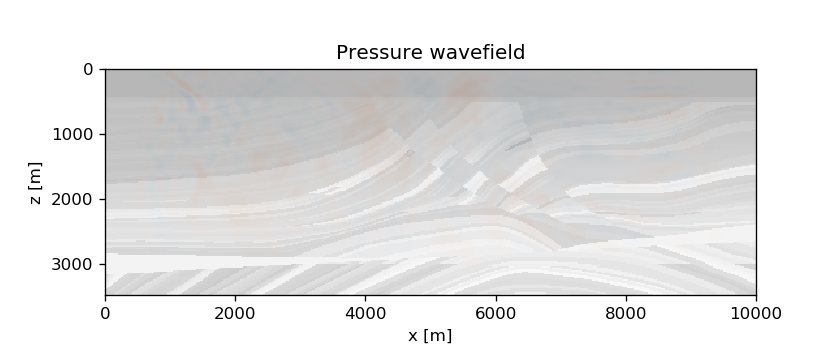

In [9]:
# Run 2D acoustic FD modelling with 3-point spatial operater
# ----------------------------------------------------------
%matplotlib notebook
op = 3  # define spatial FD operator (3-point) 

# DEFINE TIME STEP HERE!
# calculate dt according to CFL criterion
dt = 0.85 * dx / (np.sqrt(2) * np.max(vp)) # time step (s)

seis_marm_3pt = FD_2D_acoustic_JIT(vp,dt,dx,dz,f0,xsrc,zsrc,op)

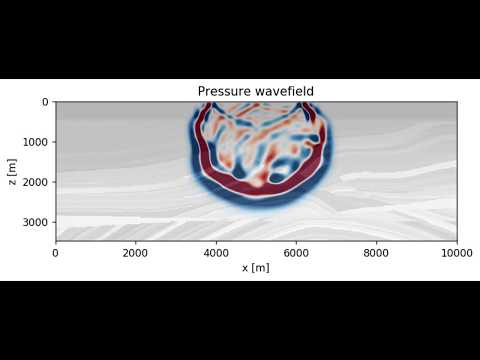

In [10]:
from IPython.display import YouTubeVideo
YouTubeVideo('IHF4vYeVKs8')

Notice, how the direct wave, excitated by the air gun in the water column is first reflected at the seafloor, and leads to a very complex seismic wavefield as soon as it propagates in the Marmousi-2 subsurface model. This wavefield consists of reflected, diffracted and refracted acoustic waves.

Finally, we can take a look at the OBC shot gather:

<IPython.core.display.Javascript object>


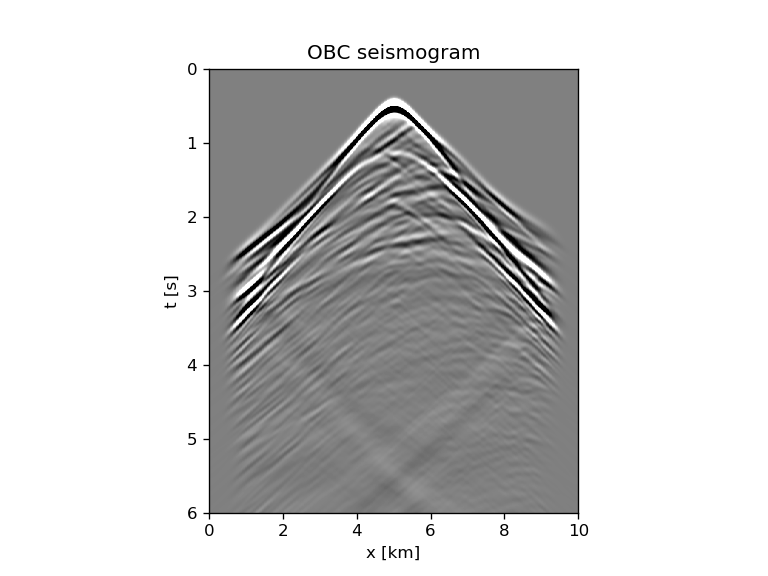

Text(0, 0.5, 't [s]')

In [11]:
%matplotlib notebook
# PLOT YOUR MODELLED OBC SHOT GATHER HERE!
clip_seis = 1e-7
extent_seis = [0.0,xmax/1000,tmax,0.0]
plt.imshow(seis_marm_3pt.T, cmap=plt.cm.gray, aspect=2, vmin=-clip_seis, 
                   vmax=clip_seis, extent=extent_seis)

plt.title('OBC seismogram')
plt.xlabel('x [km]')
plt.ylabel('t [s]')

## What we learned:

- How to model wave propgation in the complex Marmousi-2 model. Now you can model everything ...